<h1>Titolo</h1>
<h2>Analisi generale di un dataset di films</h2>

In questa prima parte ci occupiamo di eseguire le istruzioni necessarie per l'importazione di varie librerie e del dataset stesso.<br>
Inolte visualizziamo il dataset a livello strutturale

In [3]:
#importiamo le librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn.cluster as sk

#importiamo il dataset
dataset = pd.read_csv('mymoviedb.csv', lineterminator='\n')

#visualizziamo il dataset a livello strutturale
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9837 entries, 0 to 9836
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Release_Date       9837 non-null   object 
 1   Title              9828 non-null   object 
 2   Overview           9828 non-null   object 
 3   Popularity         9827 non-null   float64
 4   Vote_Count         9827 non-null   object 
 5   Vote_Average       9827 non-null   object 
 6   Original_Language  9827 non-null   object 
 7   Genre              9826 non-null   object 
 8   Poster_Url         9826 non-null   object 
dtypes: float64(1), object(8)
memory usage: 691.8+ KB


In [4]:
#visualizziamo le prime righe del dataset per avere una visione più pratica
dataset.head()

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [6]:
#vediamo i datatype delle colonne
dataset.dtypes

Release_Date          object
Title                 object
Overview              object
Popularity           float64
Vote_Count            object
Vote_Average          object
Original_Language     object
Genre                 object
Poster_Url            object
dtype: object

<h2>Pulizia del dataset</h2>

Procediamo con la prima parte dell'analisi, la pulizia del dataset, che ci permetterà di eseguire le analisi su di esso senza preoccuparci di possibili errori causati da datatype sbagliati, valori clonati o mancanti e colonne superflue.

In [10]:
#Togliamo poster_url
dataset = dataset.drop('Poster_Url', axis=1)

#troviamo i valori nulli nel dataset
dataset.isnull().sum()

Release_Date          0
Title                 9
Overview              9
Popularity           10
Vote_Count           10
Vote_Average         10
Original_Language    10
Genre                11
dtype: int64

In [12]:
#eliminiamo i valori nulli di "title" 
dataset = dataset.dropna(subset=['Title'])

#visualizziamo le modifiche
dataset.isnull().sum()

Release_Date         0
Title                0
Overview             0
Popularity           1
Vote_Count           1
Vote_Average         1
Original_Language    1
Genre                2
dtype: int64

Abbiamo notato che i valori nulli sono scesi drasticamente perchè tutti legati alle righe con titoli nulli. Ora, dato che rimangono poche righe con valori nulli, riteniamo sia legittimo rimuoverle direttamente perchè poco influenti.

In [15]:
dataset = dataset.dropna()

Adesso controlliamo se ci sono valori duplicati e nel caso li eliminiamo 

In [18]:
dataset.duplicated().sum()

0

Come possiamo vedere, non sono presenti valori duplicati

In [21]:
#convertiamo il datatype di 'Vote_average' a float e 'Vote_count' ad int
dataset['Vote_Count'] = dataset['Vote_Count'].astype(int, copy=False)
dataset['Vote_Average'] = dataset['Vote_Average'].astype(float, copy=False)
dataset.describe()
dataset.dtypes

Release_Date          object
Title                 object
Overview              object
Popularity           float64
Vote_Count             int64
Vote_Average         float64
Original_Language     object
Genre                 object
dtype: object

<h1>Visualizzazione<h1>

Per poter eseguire l'olap abbiamo prima bisogno di quantizzare tre valori per noi significativi e utili per l'analisi del dataset. Per questo dataset la scelta migliore ci è sembrata quella di quantizzare popularity, vote_average e release_date.

Per poter quantizzare nel modo migliore la popolarità, la visualizziamo in un grafico

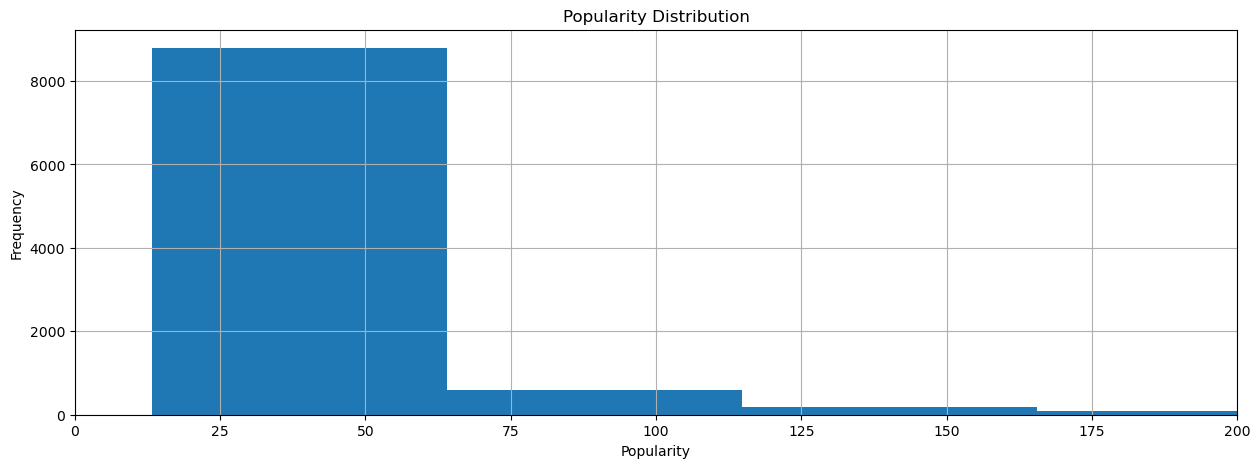

In [30]:
#visuallizziamo la distribuzione di 'Popularity'
histo = dataset['Popularity'].hist(bins=100, figsize=(15, 5))
plt.xlim(0, 200) #limitiamo l'asse y per una migliore visualizzazione
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Popularity Distribution')
plt.show()

Come possiamo vedere sono presenti più di 8000 film sotto la popolarità 60 mentre sopra questa soglia sono presenti molti meno film 

Invece per quantizzare release_date visulizziamo qualche informazione sulla data di uscita dei film

#vediamo il titolo delfilm meno recente e il più recente
dataset.Release_Date = pd.to_datetime(dataset.Release_Date)
min_date = dataset['Release_Date'].min()
max_date = dataset['Release_Date'].max()

print('Il film meno recente è:', dataset[dataset['Release_Date'] == min_date]['Title'].values[0], ', uscito il', min_date.date())
print('Il film più recente è:', dataset[dataset['Release_Date'] == max_date]['Title'].values[0], ', uscito il', max_date.date())

dataset.dtypes

Come possiao notare, nel database sono presenti dei film che non sono ancora usciti ma hanno già una data di pubblicazione ufficiale

Ora scegliamo effettivamente come quantizzare le colonne scelte

Quantizzazione delle date di uscita
1. VERY OLD = [1900, 1980]
2. OLD = [1981, 2000]
3. RECENT = [2001, 2015]
4. VERY RECENT = [2016, 2024]

Quantizziamo anche i voti
1. BAD = [0, 4.9]
2. SUFFICIENT = [5, 5.9]
3. GOOD = [6, 6.9]
4. VERY GOOD = [7, 7.9]
5. EXCELLENT = [8, 10]

Quantizziamo anche popularity
1. NOT POPULAR = [0 ,39.9] 
2. AVARAGE = [40, 59.9]
3. POPULAR = [60, 1999.9]
4. BLOCKBUSTER = [2000, 5084]

In [129]:
quantize_release_date = ['VERY OLD', 'OLD', 'RECENT', 'VERY-RECENT']
minimum = [1900, 1981, 2001, 2016]
maximum = [1980, 2000, 2015, 2024]

dataset.Release_Date = pd.to_datetime(dataset.Release_Date)
dataset.dtypes
for i in range(4):
    dataset.loc[dataset['Release_Date'].dt.year.between(minimum[i], maximum[i]), 'quant_Release_Date'] = quantize_release_date[i]

In [156]:
#Quantizziamo la colonna 'Vote_Average'
quantize_vote_average = ['VERY BAD', 'BAD', 'SUFFICIENT', 'GOOD', 'VERY GOOD']
minimum = [0, 5, 6, 7, 8]
maximum = [4.9, 5.9, 6.9, 7.9, 10]


for i in range(5):
    dataset.loc[dataset['Vote_Average'].between(minimum[i], maximum[i]), 'quant_vote_average'] = quantize_vote_average[i]


In [158]:
#Abbiamo notato che alcuni valori di Popularity hanno molte cifre decimali, quindi abbiamo deciso di arrotondarli a 1 cifra decimale
dataset['Popularity'] = dataset['Popularity'].round(1)


#Quantizziamo la colonna 'Popularity'
quantize_popularity = ['NOT POPULAR', 'AVERAGE', 'POPULAR', 'BLOCKBUSTER']
minimum = [0, 40, 60, 2000]
maximum = [39.9, 59.9, 1999.9, 5084]

for i in range(4):
    dataset.loc[dataset['Popularity'].between(minimum[i], maximum[i]), 'quant_popularity'] = quantize_popularity[i]
    


Visualizziamo il dataset per controllare le nuove colonne quantizzate

In [161]:
dataset.describe()
dataset.head()


,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,quant_Release_Date,quant_vote_average,quant_popularity,genre_encoded,release_encoded,cluster
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5084.0,8940,8.3,en,Action,VERY-RECENT,VERY GOOD,BLOCKBUSTER,1,4,2
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.7,1151,8.1,en,Crime,VERY-RECENT,VERY GOOD,BLOCKBUSTER,2,4,2
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.1,122,6.3,en,Thriller,VERY-RECENT,SUFFICIENT,BLOCKBUSTER,3,4,2
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.2,5076,7.7,en,Animation,VERY-RECENT,GOOD,BLOCKBUSTER,4,4,2
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.5,1793,7.0,en,Action,VERY-RECENT,GOOD,POPULAR,1,4,0


<h2>OLAP</h2>

Adesso creiamo l'olap per il nostro dataset, utilizzando le colonne quantizzate 
l'OLAP è utile per diverse ragioni perchè consente di visualizzare i dati da diverse prospettive, organizzandoli in dimensioni multiple. Inoltre L'OLAP è ottimizzato per consentire l'accesso rapido ai dati. 

In [165]:
OLAP = np.zeros((len(quantize_popularity), len(quantize_release_date), len(quantize_vote_average)))
for z in range(0, len(quantize_popularity)):
    for j in range(0, len(quantize_release_date)):
        for i in range(0, len(quantize_vote_average)):
            OLAP[z, j, i] = ((dataset['quant_popularity'] == quantize_popularity[z]) & 
                             (dataset['quant_Release_Date'] == quantize_release_date[j]) &
                             (dataset['quant_vote_average'] == quantize_vote_average[i])).sum()

np.set_printoptions(suppress=True)        
print(quantize_popularity)
print(quantize_release_date)
print(quantize_vote_average)
print("\n")
print(OLAP)

['NOT POPULAR', 'AVERAGE', 'POPULAR', 'BLOCKBUSTER']
['VERY OLD', 'OLD', 'RECENT', 'VERY-RECENT']
['VERY BAD', 'BAD', 'SUFFICIENT', 'GOOD', 'VERY GOOD']


[[[  16.   52.  193.  333.   76.]
  [  76.  306.  737.  439.   39.]
  [ 201.  798. 1343.  727.   60.]
  [ 220.  515.  938.  608.  100.]]

 [[   0.    1.    4.   13.    9.]
  [   1.   12.   31.   48.   14.]
  [  17.   86.  208.  115.   16.]
  [  12.   52.  148.   92.   24.]]

 [[   0.    1.    1.   13.    3.]
  [   3.    6.   23.   26.   13.]
  [   8.   54.  164.  130.   16.]
  [  39.   91.  242.  245.   64.]]

 [[   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    1.    1.    2.]]]


le "micro-matrici' sono il livello di popularity, le righe sono il livello di release_date e le colonne riguardano il livello di Vote_average.


Procediamo allo slicing dell'olap, in modo da visualizzare la matrice dei film POPULAR

In [169]:
MOVIE = OLAP[1]
print(MOVIE)

[[  0.   1.   4.  13.   9.]
 [  1.  12.  31.  48.  14.]
 [ 17.  86. 208. 115.  16.]
 [ 12.  52. 148.  92.  24.]]


creiamo un heatmap che ci consente di visualizzare rapidamente come variano i valori della matrice MOVIE. Possiamo  facilemnte vedere se ci sono determinati periodi di rilascio dei film che tendono ad avere una maggiore popolarità o se ci sono punte di popolarità in determinati intervalli di voto medio.

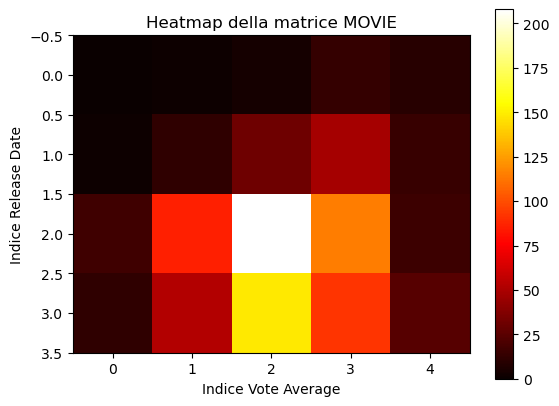

In [172]:
plt.imshow(MOVIE, cmap='hot', interpolation='nearest')
plt.colorbar()  # Aggiunge una barra dei colori per indicare il valore
plt.title('Heatmap della matrice MOVIE')
plt.xlabel('Indice Vote Average')
plt.ylabel('Indice Release Date')
plt.show()

Ora facciamo un dicing in modo da visualizzare i film VERY RECENT con votazione media SUFFICIENT

In [180]:
SUFFICIENT_and_VERYRECENT = OLAP[:,3,2]

print(SUFFICIENT_and_VERYRECENT)

[938. 148. 242.   1.]


Visualizziamolo con un grafico a barre 

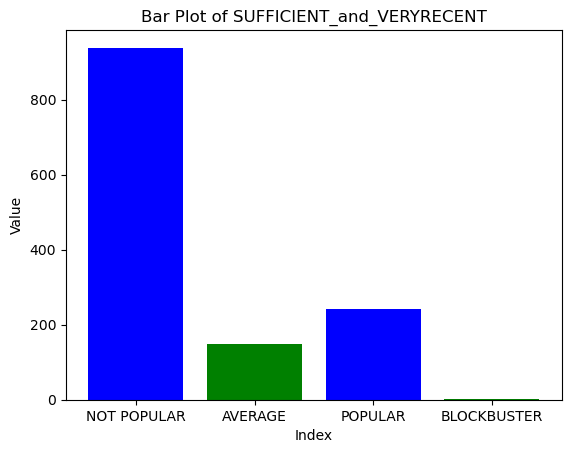

In [187]:
# Grafico a barre con l'indice sull'asse x e il valore sull'asse y
plt.bar(range(len(SUFFICIENT_and_VERYRECENT)), SUFFICIENT_and_VERYRECENT, color=['blue', 'green'])  

# Etichette degli assi
plt.xlabel('Index')
plt.ylabel('Value')

# Nomi delle categorie sugli assi x
plt.xticks(range(len(SUFFICIENT_and_VERYRECENT)), ['NOT POPULAR', 'AVERAGE', 'POPULAR', 'BLOCKBUSTER'])
  
# Titolo del grafico
plt.title('Bar Plot of SUFFICIENT_and_VERYRECENT')

# Mostra il grafico
plt.show()

si può facilemnte vedere ed è logico che i blockbuster con votazione media e recenti sono praticamente assenti mentre quelli non popolari sono moltissimi.

<h1>Test statistico</h1>


Con il test statistico, data la simile media dei voti tra i film OLD e quelli VERY-RECENT

Visualizziamo i valori di Vote_Average, separati per Genre, utilizzando dei box plot.

Prima però è necessario trasformare la colonna Genre in modo che abbia un solo genere per film

In [189]:
dataset["Genre"] = dataset["Genre"].str.split(',').str[0]
dataset.head()

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,quant_Release_Date,quant_vote_average,quant_popularity,genre_encoded,release_encoded,cluster
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5084.0,8940,8.3,en,Action,VERY-RECENT,VERY GOOD,BLOCKBUSTER,1,4,2
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.7,1151,8.1,en,Crime,VERY-RECENT,VERY GOOD,BLOCKBUSTER,2,4,2
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.1,122,6.3,en,Thriller,VERY-RECENT,SUFFICIENT,BLOCKBUSTER,3,4,2
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.2,5076,7.7,en,Animation,VERY-RECENT,GOOD,BLOCKBUSTER,4,4,2
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.5,1793,7.0,en,Action,VERY-RECENT,GOOD,POPULAR,1,4,0


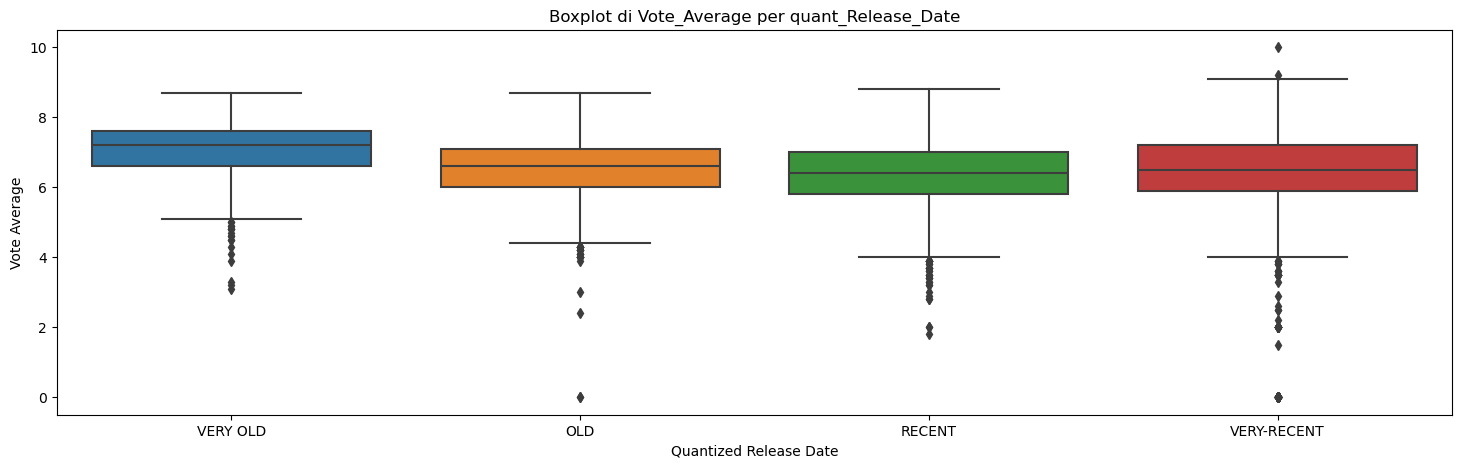

In [197]:
# Crea il boxplot con le etichette sull'asse x nell'ordine desiderato
plt.figure(figsize=(18, 5))
sns.boxplot(data=dataset, x='quant_Release_Date', y='Vote_Average', order= ['VERY OLD', 'OLD', 'RECENT', 'VERY-RECENT'])
plt.title('Boxplot di Vote_Average per quant_Release_Date') 
plt.xlabel('Quantized Release Date')
plt.ylabel('Vote Average')
plt.show()

In [193]:
old_count = dataset[dataset['quant_Release_Date'] == 'OLD'].shape[0]
very_recent_count = dataset[dataset['quant_Release_Date'] == 'VERY-RECENT'].shape[0]

print("Number of elements in class OLD:", old_count)
print("Number of elements in class VERY-RECENT:",very_recent_count)

Number of elements in class OLD: 1774
Number of elements in class VERY-RECENT: 3394


In [73]:
old_count = dataset[dataset['quant_Release_Date'] == 'OLD']["Vote_Average"]
very_recent_count = dataset[dataset['quant_Release_Date'] == 'VERY-RECENT']["Vote_Average"]

# Perform t-test
t_stat, p_value = stats.ttest_ind(old_count, very_recent_count)

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. The means are statistically different.")
else:
    print("Fail to reject the null hypothesis. The means are not statistically different.")
#DA VERIFICARE

T-statistic: 5.127906522153585
P-value: 3.036758000146715e-07
Reject the null hypothesis. The means are statistically different.


<h1>Metodo predittivo</h1>

Text(0.5, 0, 'Genre')

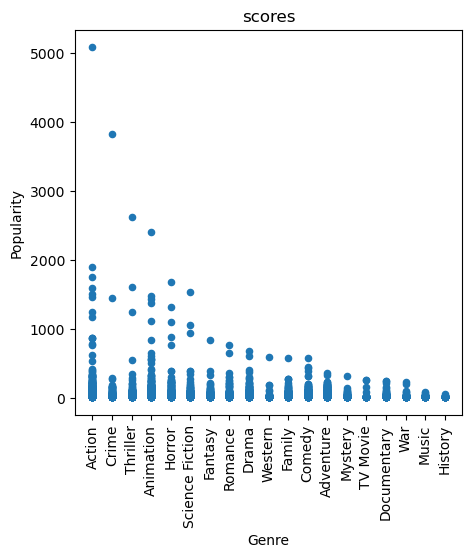

In [76]:
dataset.plot(kind ='scatter',y='Popularity', x='Genre', figsize = (5,5))
plt.xticks(rotation=90)
plt.title('scores')
plt.ylabel('Popularity')
plt.xlabel('Genre')


#deduciamo se c'è correlazione 

In [77]:
genre_mapping = {'Action': 1, 'Crime': 2, 'Thriller': 3, 'Animation': 4, 
                 'Horror': 5, 'Science Fiction': 6, 'Fantasy': 7, 'Romance': 8,
                'Drama': 9, 'Western': 10, 'Family': 11, 'Comedy': 12, 
                 'Adventure': 13, 'Mystery': 14, 'TV Movie': 15,'Documentary': 16,
                 'War': 17, 'Music': 18,'History': 19}

# Map genre column to numerical values
dataset['genre_encoded'] = dataset['Genre'].map(genre_mapping)

correlation = dataset[['Popularity','genre_encoded']].corr()
print(correlation)

               Popularity  genre_encoded
Popularity       1.000000      -0.082829
genre_encoded   -0.082829       1.000000


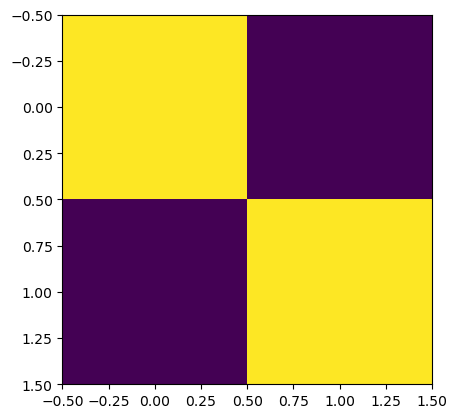

In [80]:
plt.imshow(correlation)

In [81]:
from sklearn.model_selection import train_test_split

# Definire le caratteristiche da usare
features = ['Vote_Average']

# Definire X e y
X = dataset[features]
y = dataset['Popularity']

# Dividere il dataset in training e validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2)

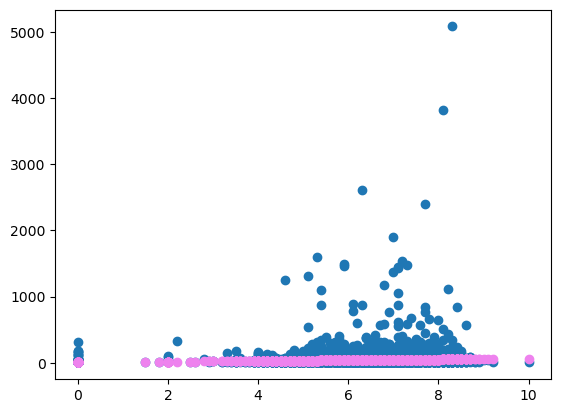

In [84]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
reg = regressor.fit(X_train, y_train)
y_pred = reg.coef_*X_train + reg.intercept_
plt.scatter(X_train,y_train)
plt.scatter(X_train,y_pred,color="violet")

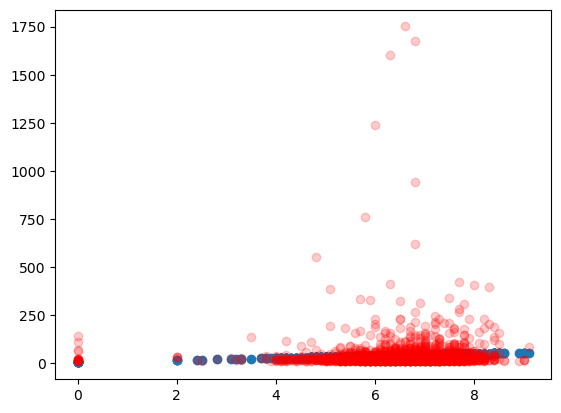

In [85]:
y_hat = reg.predict(X_valid)
plt.scatter(X_valid,y_hat)
plt.scatter(X_valid,y_valid,c='r',alpha=0.2)

<h1>Clustering </h2>

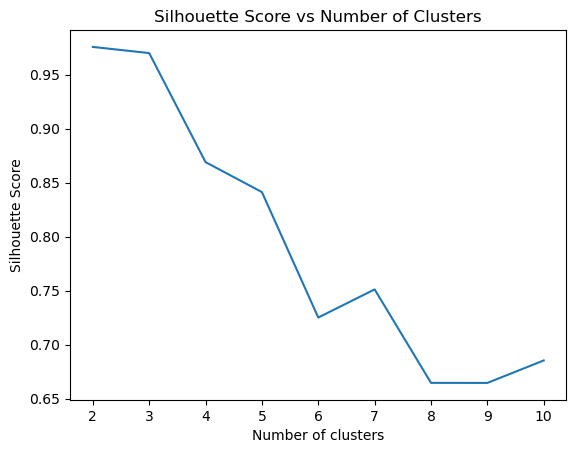

In [91]:
from sklearn import metrics
release_mapping = {'VERY OLD': 1, 'OLD': 2, 'RECENT': 3, 'VERY-RECENT': 4}

# Map genre column to numerical values
dataset['release_encoded'] = dataset['quant_Release_Date'].map(release_mapping)

#Facciamo silhuette per vedere il numero di cluster
X = dataset[['Vote_Average', 'Popularity', 'release_encoded', 'genre_encoded']]
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans = sk.KMeans(n_clusters=k, n_init=kmax).fit(X)
    labels = kmeans.labels_
    sil.append(metrics.silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(range(2, kmax+1), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

Text(0.5, 0, 'Vote_Average')

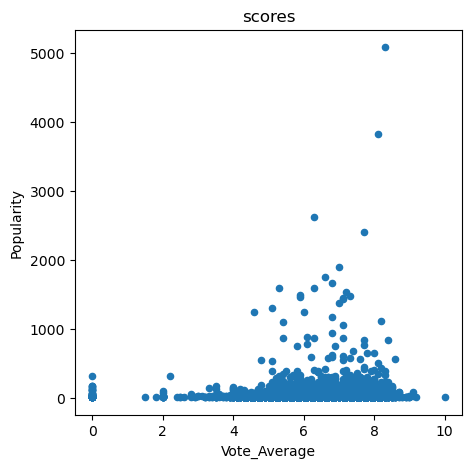

In [93]:
dataset.plot(kind ='scatter',y='Popularity', x='Vote_Average', figsize = (5,5))
plt.title('scores')
plt.ylabel('Popularity')
plt.xlabel('Vote_Average')


#deduciamo se c'è correlazione 

In [95]:
correlation = dataset[['Popularity','Vote_Average']].corr()
print(correlation)

              Popularity  Vote_Average
Popularity      1.000000      0.053837
Vote_Average    0.053837      1.000000


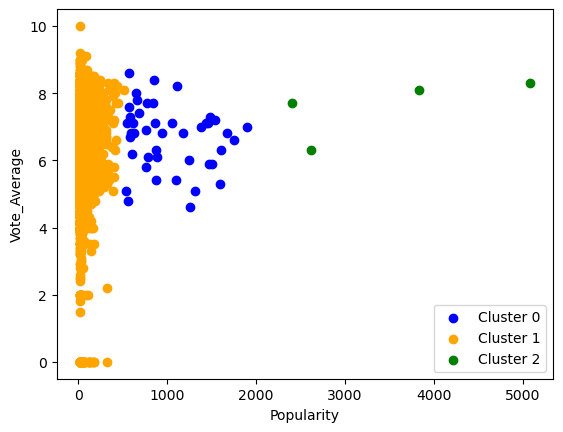

In [99]:
kmeans = sk.KMeans(n_clusters=3, random_state=1, n_init=kmax)

clusters = kmeans.fit_predict(dataset[["Popularity", "Vote_Average","genre_encoded","release_encoded"]])
dataset["cluster"] = clusters
y = kmeans.labels_

color = ['b','orange','g']

for i in range(0, 3):
    plt.scatter(dataset.loc[dataset['cluster'] == i, 'Popularity'], 
                dataset.loc[dataset['cluster'] == i, 'Vote_Average'], 
                color=color[i], label='Cluster ' + str(i))

plt.xlabel('Popularity')
plt.ylabel('Vote_Average')
plt.legend()
plt.show()